# ATOM

Auteurs : Rémi Morvan & Philippe Mathieu (CRISTAL/SMAC, université de Lille)

Date : 2018

ATOM est une modèle de marché financié dirigé par les ordres avec lequel des agents traders artificiels peuvent intéragir. Il permet notamment de voir les conséquences d'exécutions d'ordres, de tester des comportements de traders ou de tester des règles de régulation de marché. ATOM peut gérer des milliers d'agents siltanément sur un marché multi-options à double carnet d'ordres de type Euronext-NYSE.

# Prise en main d'Atom

In [1]:
from atom import *
from data_processing import *
import numpy as np
import random
import statsmodels.tsa.stattools as stats
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)

## Tutoriel

Pour créer un marché, il suffit de faire `Market(assets)`, où `assets` est la liste des assets du marché. De base, il existe deux types d'agents :
* Des dumb agents, qui n'envoient aucun ordre hormis ceux qu'on leur demande d'envoyer
* Des ZIT, qui envoient, à chaque fois qu'ils ont la parole, un ordre aléatoire, dont le prix est tiré uniformément entre 1000 et 9999 et la quantité entre 1 et 9.

Pour créer ces agents, le marché doit leur être passé en paramètre. La méthode `add_trader` du marché permet de rajouter les agents au marché.

### Dumb Agents

Un dumb agent n'est qu'un intermédiaire entre nous et le marché pour qu'on puisse envoyer l'ordre que l'on souhaite. Pour ce faire, on utilise la méthode `send_order` de l'agent, qui prend en paramètres un ordre et le marché.

Le premier type d'ordre est les limit orders, que l'on créé avec la commande `LimitOrder(asset, source, direction, price, qty)`.

In [2]:
m = Market(['Apple', 'Google']) # Créé un marché dont les assets sont 'Apple' et 'Google'
t = DumbAgent(m, name='pauline') # Créé un dumb agent
m.add_trader(t) # Rajoute le dumb agent au marché

t.send_order(LimitOrder('Apple', t, 'ASK', 5000, 10), m)
# Le dumb agent a envoyé au marché un ordre de vente de 10 actions Apple au prix 5000
t.send_order(LimitOrder('Apple', t, 'BID', 6000, 5), m)
# Le dumb agent a envoyé au marché un ordre d'achat de 5 actions Apple au prix 6000

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;pauline;0;Apple:0,Google:0
AgentWealth;pauline;0;0
LimitOrder;Apple;pauline;ASK;5000;10;0
LimitOrder;Apple;pauline;BID;6000;5;0
Price;Apple;pauline;pauline;5000;5;0
Agent;pauline;0;Apple;0;0
AgentWealth;pauline;0;0


### Trace

Atom peut fournir durant l'exécution une trace de toutes les opérations effectuées. Cela permet de voir précisément quelles sont les opérations réalisées par les agents et les conséquences de ces différentes opérations. Les premières lignes (commençant par '#') de cette trace précisent la syntaxe utilisée.
* Les lignes LimitOrder et CancelMyOrders sont affichées quand un ordre (LimitOrder ou CancelMyOrders) a été envoyé
* Les lignes Tick correspondent à une fin de tick
* Les lignes Price sont affichées quand un prix est fixé (long fixing)
* Les lignes NewAgent sont affichées quand un agent est rajouté au marché
* Les lignes Agent sont affichées quand un agent a son cash ou sa quantité d'actions qui sont modifées
* Les lignes AgentWealth correspondent au wealth des agents

On peut diriger cette trace sur différentes sorties (écran, fichier, pas de trace) à l'aide du paramètre `out` , lors de la création du marché :
* Si rien n'est précisé, la trace est affichée dans la console
* Si `out = None`, rien n'est affiché
* Si `out = FileObject`, la trace est affichée dans un fichier. Si on utilise cette méthode, il est impératif de penser à fermer le fichier après qu'on ait fini d'écrire dedans.

In [3]:
file = open('trace.dat', 'w') # On ouvre le fichier trace.dat en écriture

m = Market(['Apple'], out=file) # On donne ce fichier au marché
t = DumbAgent(m)
m.add_trader(t)
t.send_order(LimitOrder('Apple', t, 'ASK', 5000, 10), m)

file.close() # On n'oublie pas de fermer le fichier.

Une méthode `print_state()` fournie par marché, affiche le nombre d'ordres reçus, le nombre de prix fixés et le nombre d'ordres ASK et BID en attente.

In [4]:
m = Market(['Apple'])
t = DumbAgent(m, name='paul')
m.add_trader(t)
t.send_order(LimitOrder('Apple', t, 'ASK', 5000, 10), m)
t.send_order(LimitOrder('Apple', t, 'BID', 6000, 5), m)
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;paul;0;Apple:0
AgentWealth;paul;0;0
LimitOrder;Apple;paul;ASK;5000;10;0
LimitOrder;Apple;paul;BID;6000;5;0
Price;Apple;paul;paul;5000;5;0
Agent;paul;0;Apple;0;0
AgentWealth;paul;0;0
# Nb orders received: 2
# Nb fixed prices: 1
# Leaving ask size: 1
# Leaving bid size: 0


### ZITs

Les ZITs peuvent être créés de la même façon que les dumb agents, en utilisant la commande `ZITTrader(m)`. Une fois les ZITs créés et ajoutés au marché, on peut utiliser la méthode du marché `run_once()`, qui donne la parole à chaque agent sur chaque asset.

In [5]:
m = Market(['Apple'])
m.add_trader(ZITTrader(m))
m.add_trader(ZITTrader(m))
m.run_once()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;ZIT 4;0;Apple:0
AgentWealth;ZIT 4;0;975360
NewAgent;ZIT 5;0;Apple:0
AgentWealth;ZIT 5;0;975360
LimitOrder;Apple;ZIT 4;BID;4092;1;975360
LimitOrder;Apple;ZIT 5;ASK;5803;5;975360
Tick;1;975360


On peut aussi utiliser la méthode du maché `generate(nb_ZIT, nb_turn)`, qui créé nb ZITS, les ajoute au marché et fait nb_turn tours de parole. Le code précédent est donc équivalent au code suivant :

In [6]:
m = Market(['Apple'])
m.generate(2, 1)

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;ZIT 6;0;Apple:0
AgentWealth;ZIT 6;0;1002752
NewAgent;ZIT 7;0;Apple:0
AgentWealth;ZIT 7;0;1002752
LimitOrder;Apple;ZIT 6;ASK;8091;4;1002752
LimitOrder;Apple;ZIT 7;ASK;3767;8;1002752
Tick;1;1002752


### Pour aller plus loin...

Finalement, tous les agents ont deux paramètres facultatifs :
* `initial_assets`, qui est une liste de même taille que la liste des assets du marché, et qui contient l'ensemble des assets dont disposent les agents. Si rien n'est précisé, on suppose que c'est une liste remplie de zéros.
* `cash`, qui est le cash initial dont dispose l'agent et qui vaut 0 si rien n'est précisé.

Par exemple, si `m = Market(['Apple', 'Google'])`, alors la commande `m.add_trader(ZITTrader(m, [5, 10], 5000))` rajoute au marché un ZIT qui dispose initialement d'un cash de 5000, de 5 actions d'Apple et de 10 actions de Google.

La méthode `generate` dispose elle de deux paramètres `init_assets` et `init_cash`, qui sont tous deux des entiers. Chaque ZIT est alors créé avec un cash initial égal à `init_cash` et disposant, pour chaque asset, de `init_assets` actions.

En outre, le marché possède un paramètre optionnel `fix`, valant `'L'` par défaut (long fixing), et pouvant aussi valoir `'S'` (short fixing).

Finalement, on peut passer au marché un paramètre `trace`, auquel on peut donner les valeurs suivantes :
* `'all'` : toutes les informations sont écrites dans la trace, même les carnets d'ordres
* `'all except orderbooks'` (valeur par défaut) : comme `all`, mais les carnets d'ordres ne sont pas écrits
* une sous-liste de `['order', 'tick', 'price', 'agent', 'newagent', 'wealth', 'orderbook']` : les valeurs présentes dans cette sous-lignes correspondent aux types d'informations qu'on veut voir écrites dans la trace

Par exemple, si `trace=['price', 'wealth']`, alors seules les lignes "Price" et "AgentWealth" seront écrites.

In [7]:
m = Market(['Apple', 'Google'], trace='all')
m.generate(2, 3, 10, 10000)
m.print_state()
# Créé 2 ZIT, qui vont faire 3 tours de parole
# et qui ont initialement 10000 de cash, 10 actions Apple et 10 actions Google

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick;timestamp
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)
NewAgent;ZIT 8;10000;Apple:10,Google:10
AgentWealth;ZIT 8;110000;0
NewAgent;ZIT 9;10000;Apple:10,Google:10
AgentWealth;ZIT 9;110000;0
LimitOrder;Apple;ZIT 8;BID;7573;5;0
OrderBook Apple:
Asks:
	Empty
Bids:
	LimitOrder;Apple;ZIT 8;BID;7573;5;0
LimitOrder;Google;ZIT 8;BID;5698;7;0
OrderBook Google:
Asks:
	Empty
Bids:
	LimitOrder;Google;ZIT 8;BID;5698;7;0
LimitOrder;Apple;ZIT 9;ASK;9264;5;0
OrderBook Apple:
Asks:
	LimitOrder;Apple;ZIT 9;ASK;9264;5;0
Bids:
	LimitOrder;Apple;ZIT 8;BID;7573;5;0
LimitOrder;Google;ZIT 9;ASK;6543;7;0
OrderBook Google:
Asks:
	LimitOrder;Google;ZIT 9;ASK;6543;7;0
Bids:
	LimitOrder;Google;ZIT 8;BID;5698;7;0
Tick;1;0
LimitOrder;Apple;ZIT 8;ASK;7184;3;0
OrderBook Apple:
Asks:
	LimitOrde

Les orderbooks sont affichés à chaque fois qu'ils sont modifiés.

## Utilisation de la trace pour afficher différentes courbes

In [8]:
file = open('trace.dat', 'w')

m = Market(['Apple', 'Google'], out=file)
m.generate(3, 100, 10, 0)
m.print_state()

file.close()

### Affichage des prix

On peut extraire les prix de la trace à l'aide de la fonction `extract_prices`, qui prend en entrée un nom de fichier, et retourne un dictionnaire dont les clés sont les assets et les valeurs sont des tuples (T, P), avec T la liste des timestamps et P la liste des prix correspondants (pour un asset donné).

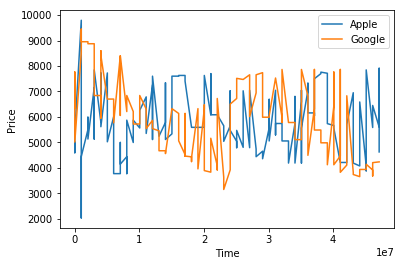

In [9]:
Prices = extract_prices('trace.dat')
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

### Affichage de l'évolution du wealth des agents

À la fin d'une simulation, on peut accéder au wealth d'un agent avec la méthode `get_wealth` (qui prend le marché en paramètre). Par exemple, on peut afficher les caractéristiques (avec la méthode `get_infos`) de l'agent le plus riche et du plus pauvre:

In [10]:
t_max = m.traders[0]
t_min = m.traders[0]
for t in m.traders: # On parcourt l'ensemble des traders
    if t.get_wealth(m) > t_max.get_wealth(m):
        t_max = t
    elif t.get_wealth(m) < t_max.get_wealth(m):
        t_min = t
print("Agent le plus riche - "+t_max.get_infos(m))
print("Agent le plus pauvre - "+t_min.get_infos(m))

Agent le plus riche - ZIT 10:
Cash: 414029
Apple: 9
Google: -62
Wealth: 193146

Agent le plus pauvre - ZIT 11:
Cash: -385262
Apple: 76
Google: 4
Wealth: -16826



Il est bien sûr d'afficher l'évolution du wealth de tous les agents, en lisant la trace : la fonction `extract_wealths` prend un nom de fichier en entrée et retourne un dictionnaire dont les clés sont les agents et les valeurs sont des listes (T, W) où T est la liste des timestamps et W la liste des wealths de cet agent.

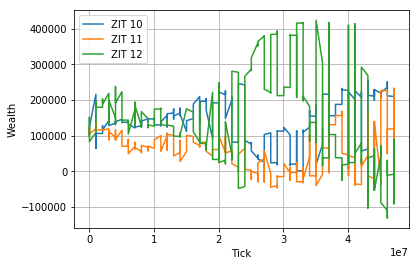

In [11]:
Wealth = extract_wealths('trace.dat')
for agent in Wealth.keys():
    T, W = Wealth[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Tick')
plt.ylabel('Wealth')
plt.show()

Il est également possible avec `extract_cash` de récuperer un dictionnaire de même structure pour le cash de chaque Agent.

### Affichage des rentabilités

On peut bein sûr afficher la séquence des rentabilités en utilisant numpy : si $p_n$ est le $n$-ème élément de Prices, alors
> (Prices[1:]-Prices[:-1])/Prices[:-1] (resp. np.log(Prices[1:]) - np.log(Prices[:-1]))

donne la séquence des $\dfrac{p_{n+1}-p_n}{p_n}$ (resp. $\ln(p_{n+1})-\ln(p_n)$).

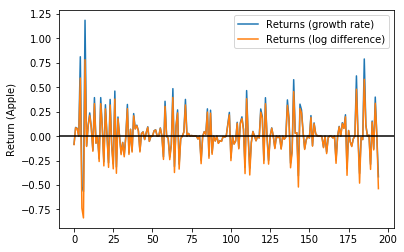

In [12]:
asset = 'Apple'
Prices = np.array(extract_prices('trace.dat')[asset][1])
Returns = (Prices[1:]-Prices[:-1])/Prices[:-1]
Returns_eco = np.log(Prices[1:]) - np.log(Prices[:-1])
plt.plot(Returns, '-', label="Returns (growth rate)")
plt.plot(Returns_eco, '-', label="Returns (log difference)")
plt.axhline(0, color='k')
plt.ylabel('Return ('+asset+')')
plt.legend(loc='best')
plt.show()

On peut afficher l'histogramme des rentabilités (définies comme la différence logarithmique). Pour cela, on dispose d'une fonction `process_returns_hist`, qui prend en entrées le nom du fichier dans lequel la trace est stockée, le nom de l'asset pour lequel on va calculer les rentabilités, et un nombre de points. En retour, on obtient un tuple (R, D, N) où R est une liste des rentabilités, D la liste de leur densités et N la densité de la loi normale de même espérance et de même écart-type.

In [13]:
# On fait notre generate
# Mieux vaut avoir beaucoup de points, même si c'est un peu long à calculer.
file = open('trace.dat', 'w')
asset = 'Apple'
m = Market([asset], out=file, trace=['price'])
# On n'écrit que les prix dans la trace : ce sont les seules lignes dont on a besoin
# et ça permet de gagner un peu de temps de calcul
m.generate(10, 10000)
file.close()

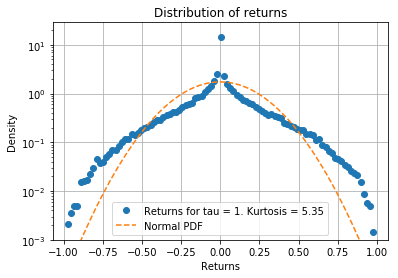

In [14]:
draw_returns_hist('trace.dat', asset, 100)

On observe bien le fait stylisé associé à la rentabilité : par rapport à une gaussienne de même espérance et même écart type, on a une forte kurtosis (pic central de plus grande amplitude) et des queues plus épaisses.

Remarque : Pourquoi choisir la différence logarithmique plutôt que le taux d'accroissement ?
Parce que la différence logarithmique a une belle propriété : si on passe d'un prix $p$ à un prix $p'$, alors la rentabilité sera de $r_1 = \log(p') - \log(p)$ ; si on passe de $p'$ à $p$, on a une rentabilité de $r_2 = log(p) - log(p') = -r_1$. Cette propriété n'est pas vérifiée par le taux d'accroissement : si on se limite à des prix tirés entre 1000 et 10000, le taux d'accroissement maximal est 9, et le taux d'accroissement minimal est $-0.9$. La distribution des rentabilités définies comme taux d'accroissement ne sera donc pas symétrique.

Remarque 2 : Cette distinction est importante car on travaille avec ZIT qui font que les prix peuvent subir de fortes variations soudaines. Sur un vrai marché, ces variations sont faibles, et donc si on passe d'un prix $p$ à un prix $p'$, on a $\Delta(p) = |p'-p| << p$, donc : $log(p') - log(p) = \log\left(1+\dfrac{p'-p}{p}\right) \sim \dfrac{p'-p}{p}$. Ainsi, sur un vrai marché, peut importe la définition choisie, on aura grosso modo le même résultat.

### Histogramme des rentabilité quand les prix sont fixés aléatoirement

Le but de cette partie est de montrer que le fait stylisé qu'on obtient avec un marché financier à carnet d'ordres asynchrone ne peut être obtenu avec des prix fixés aléatoirement.
Pour illustrer cela, nous allons générer une fausse trace dans laquelle des prix (500000) sont fixés aléatoirement uniformément entre 1 et 100.

In [15]:
# On créé notre ausse trace dans laquelle les prix sont fixés aléatoirement.
out = open('fake_trace.dat', 'w')
t0 = int(time.time()*1000000)
for i in range(5000000):
    out.write("Price;Apple;Agent 0;Agent 0;%i;1;%i\n" % (random.randint(1000, 9999), int(time.time()*1000000)-t0))
out.close()

On va alors afficher l'histogramme des rentabilités.

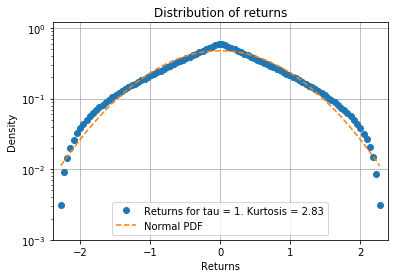

In [16]:
draw_returns_hist('fake_trace.dat', 'Apple', 100)

On n'observe plus une sorte de gausienne avec un gros pic et des queues épaisses, mais, près du centre, deux demi-droites qui aux extrémités ont une queue moins épaisse que la gaussienne. Les prix fixés par un système à carnet d'ordres ne sont donc clairement pas de même structure qu'un simple tirage aléatoire, même si les agents eux mêmes ne font que des choix aléatoire.

### Affichage de l'autocorrélation des rentabilités

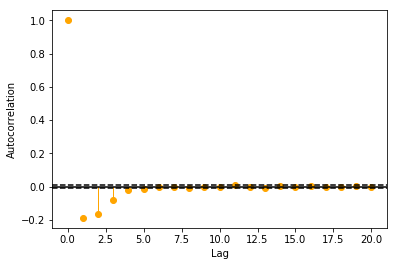

In [17]:
Prices = np.array(extract_prices('trace.dat')[asset][1])
Returns = np.log(Prices[1:]) - np.log(Prices[:-1])
acf = stats.acf(Returns, nlags=20,fft=False)
plt.plot(range(21), acf, 'o', color="orange")
plt.bar([x+0.02 for x in range(21)], acf, .04, color="orange")
plt.axhline(0, color='k')
sigma = max(np.abs(acf[10:]))
plt.axhline(sigma, color='k', linestyle='--')
plt.axhline(-sigma, color='k', linestyle='--')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

## Utilisation de replay

ATOM peut aussi être utilisé en "flow-replayer". La méthode `replay` du marché permet de inscrites dans ce fichier. Le contenu de ce type de fichier est exactement le même qu'un fichier trace de ATOM, mais Replay ne lit que les créations d'agents et les ordres envoyés (les lignes "NewAgent" et "Order").
Il est donc possible de générer une trace avec `generate`et rejouer le fichier obtenu via `replay`. ATOM offre comme on lpeut le voir, un cercle vertueux.

In [18]:
m = Market(['LVMH'], trace=['price'])
m.replay('orderFileEx1.dat')
m.print_state()

# Price;asset;bider;asker;price;qty;timestamp(µs)
Price;LVMH;23;23;45500;10;5017088
Price;LVMH;23;23;45800;10;5017088
Price;LVMH;23;23;45800;7;5017088
Price;LVMH;23;23;45500;3;5017088
Price;LVMH;23;23;42000;2;5017088
Price;LVMH;23;23;42000;12;5017088
Price;LVMH;23;23;34000;18;5017088
Price;LVMH;23;23;34000;11;5017088
Price;LVMH;23;23;34000;5;5017088
# Nb orders received: 11
# Nb fixed prices: 9
# Leaving ask size: 0
# Leaving bid size: 0


On va regarder ce qu'il se passe si on choisit le short fixing.

In [19]:
m = Market(['LVMH'], trace=['price'], fix='S')
m.replay('orderFileEx1.dat')
m.print_state()

# Price;asset;bider;asker;price;qty;timestamp(µs)
Price;LVMH;24;24;45500;10;1019904
Price;LVMH;24;24;45800;10;1019904
Price;LVMH;24;24;42000;2;1019904
Price;LVMH;24;24;42000;12;1019904
Price;LVMH;24;24;34000;18;1019904
Price;LVMH;24;24;34000;11;1019904
Price;LVMH;24;24;34000;5;1019904
# Nb orders received: 11
# Nb fixed prices: 7
# Leaving ask size: 0
# Leaving bid size: 0


Avec le short fixing, on constate que 7 prix qui sont fixés, contre 9 pour le long fixing.

### Cercle vertueux

On va générer une trace avec `generate`, puis faire un `replay` sur cette trace. On devrait observer que l'état final du système est identique dans les deux cas. Pour être sûr que `replay` ne triche pas, on va uniquement afficher les ligne NewAgent et LimitOrder dans la trace.

In [20]:
file = open('trace.dat', 'w')
m = Market(['Apple', 'Google', 'Microsoft'], out=file, trace=['newagent', 'order'])
m.generate(2, 1000, init_assets=10, init_cash=100000)
file.close()

for t in m.traders:
    print(t.get_infos(m))

ZIT 25:
Cash: 1049520
Apple: -243
Google: 54
Microsoft: 76
Wealth: 322713

ZIT 26:
Cash: -849520
Apple: 263
Google: -34
Microsoft: -56
Wealth: 229367



In [21]:
m2 = Market(['Apple', 'Google', 'Microsoft'], out=None)
m2.replay('trace.dat')

for t in m2.traders:
    print(t.get_infos(m2))

27:
Cash: 1049520
Apple: -243
Google: 54
Microsoft: 76
Wealth: 322713

28:
Cash: -849520
Apple: 263
Google: -34
Microsoft: -56
Wealth: 229367



C'est bien ce qu'on observe ! (Nos agents ont juste des noms différents.)

## Exercices

### Génération de marché

**1. Générez un fichier `mytrace.dat` à 1 seul carnet d’ordres et 3 ZITs avec initialement 10 actions et 1000 de cash, s’exécutant durant 100 tours de parole**


In [22]:
# Réponse

file = open('mytrace.dat', 'w')

m = Market(['Apple'], out=file)
m.generate(3, 200, 10, 1000)
m.print_state()

file.close()


**2. Affichez l'évolution du court de l'action**

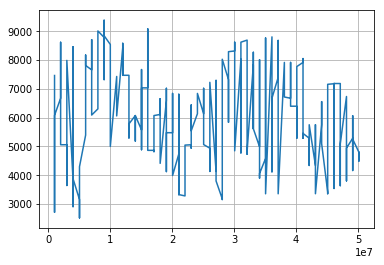

In [23]:
# Réponse

prices = extract_prices('mytrace.dat')
plt.plot(prices["Apple"][0],prices["Apple"][1])
plt.grid()
plt.show()

**3. Affichez l'évolution des quantités d'actions échangées (diagramme à barres) grâce à la fonction `extract_qties`**

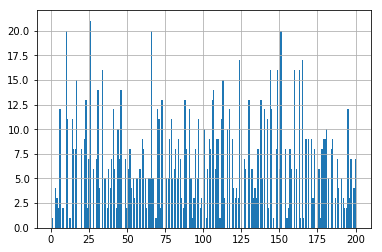

In [24]:
# Réponse

qties = extract_qties('mytrace.dat')
plt.bar(qties[0],qties[1])
plt.grid()
plt.show()

**4. Affichez l'évolution de la wealth et du cash (`extract_cash`) de l'agent le plus riche à la fin (le nom d'un trader t peut être obtenu grâce à son id : t.trader_id)**

Agent le plus riche - ZIT 31:
Cash: -133875
Apple: 58
Wealth: 144409



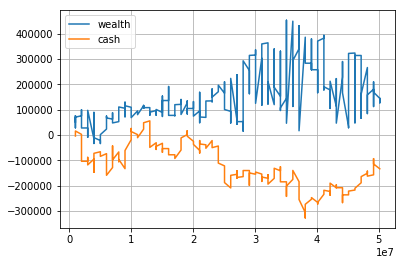

In [25]:
# Réponse

t_max = m.traders[0]
for t in m.traders: # On parcourt l'ensemble des traders
    if t.get_wealth(m) > t_max.get_wealth(m):
        t_max = t

print("Agent le plus riche - "+t_max.get_infos(m))
name = "ZIT "+str(t_max.trader_id)
Wealth = extract_wealths('mytrace.dat')
Cash = extract_cash('mytrace.dat')
plt.plot(Wealth[name][0],Wealth[name][1],label="wealth")
plt.plot(Cash[name][0],Cash[name][1],label="cash")
plt.legend(loc='best')
plt.grid()
plt.show()
